## Portfolio Optimizer setup through yfinance API with data importing and cleansing

In [1]:
#Imports
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import hvplot.pandas
import numpy as np
import pypfopt
import matplotlib.pyplot as plt
from pypfopt.expected_returns import mean_historical_return
from pypfopt import plotting
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
import seaborn as sns
import scipy.optimize as sco

# Portfolio Optimizer
### Enter US stocks as ticker only. ASX stock enter .AX after ticker e.g.(BHP.AX)
### Enter the corrosponding Index as the LAST ticker e.g(NDX)

In [2]:
# # META
# # AAPL
# # MSFT
# # GOOG
# # AMZN
# # NDX
# # 
# #US Stocks enter ticker only. ASX stocks enter ticker + .AX e.g.(BHP.AX) SET INDEX AS LAST TICKER

# tickers = []  # Initialize an empty list to store tickers

# while True:
#     ticker = input("Enter a ticker (or 'done' to finish): ")
#     if ticker.lower() == 'done':
#         break  # Exit the loop if the user enters 'done'
#     tickers.append(ticker)

# print("List of tickers:", tickers)

#### Lets start with a hardcoded list 

In [3]:
# tickers = ['META', 'AAPL', 'MSFT', 'GOOG', 'AMZN']     #
# index_symbol = ['^SPX']

tickers = ['BHP.AX', 'RIO.AX', 'ANZ.AX', 'CBA.AX', 'WOW.AX' ]     #
index_symbol = ['^AXJO']

In [4]:
def get_securities_prices(tickers, num_years=10): 

    # Calculate the start and end dates for the past 5 years
    end_date = datetime.today().date()
    start_date = end_date - timedelta(days=num_years*365)  

    # ================================Historical data of Securities=====================================

    # Fetch historical price data
    stock_data = yf.download(tickers, start=start_date, end=end_date)

    #Drop Nulls. Remove high, low, open data. 
    stock_data = stock_data.drop(columns=['Open', 'Volume', 'Close', 'High', 'Low'])

    stock_data.columns = stock_data.columns.droplevel(0) if len(tickers) > 1 else tickers

    # ================================US Treasury Bonds data=============================================
    # Fetch Risk Free rate using US10 Treasury Bond
    # Fetch historical price data
    us10_data = yf.download("^TNX", start=start_date, end=end_date)

    #Drop Nulls. Remove high, low, open data. 
    us10_data = us10_data.drop(columns=['Open', 'Volume', 'Close', 'High', 'Low'])

    return stock_data,  us10_data

In [5]:
stock_data, us10_data = get_securities_prices(tickers + index_symbol, num_years = 10)

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
#Calculate daily change stocks
combined_returns = stock_data.pct_change().dropna()
#Calculate daily change 10yr treasury
us10_daily_change = us10_data.pct_change().dropna()

## Plotting and Statistical Analysis for the Chosen Portfolio

In [7]:
# Calculate cumulative returns of all portfolios
cum_returns = (1 + combined_returns).cumprod(axis=0)

# Plot cumulative returns
cum_returns.hvplot(
    width=1000,
    height=500
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [8]:
#Calcuate rolling 180 day mean of cumulative stock price returns
cum_returns.rolling(window=180).mean().hvplot(title="SMA 180 days")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [9]:
#Calculate rolling 180 standard deviation of cumulative stock prices
cum_returns.rolling(window=180).std().hvplot(title="Rolling 180 days Standard Dev.")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [10]:
#Calculate varience
portfolio_variance = combined_returns.var()
portfolio_variance
portfolio_variance.hvplot.bar( title="Variance")

:Bars   [index]   (0)

In [11]:
# Calculate the annualized `std`
portfolio_std = combined_returns.std() * np.sqrt(252)
#portfolio_std.plot(kind="bar", title="Sharpe Ratios")
portfolio_std.hvplot.bar( title="annualised standard deviation")

:Bars   [index]   (0)

In [12]:
#Find covariance of stocks with Index
cov_matrix = combined_returns.cov()
cov_matrix

ANZ.AX    BHP.AX    CBA.AX    RIO.AX    WOW.AX     ^AXJO
ANZ.AX  0.000215  0.000114  0.000159  0.000089  0.000068  0.000111
BHP.AX  0.000114  0.000332  0.000099  0.000258  0.000068  0.000115
CBA.AX  0.000159  0.000099  0.000175  0.000077  0.000074  0.000102
RIO.AX  0.000089  0.000258  0.000077  0.000290  0.000051  0.000095
WOW.AX  0.000068  0.000068  0.000074  0.000051  0.000167  0.000065
^AXJO   0.000111  0.000115  0.000102  0.000095  0.000065  0.000093

In [13]:
#Find variance of the Index ticker
variance_of_index = combined_returns[index_symbol[0]].var()
variance_of_index

9.2530410214961e-05

In [14]:
cov_matrix

ANZ.AX    BHP.AX    CBA.AX    RIO.AX    WOW.AX     ^AXJO
ANZ.AX  0.000215  0.000114  0.000159  0.000089  0.000068  0.000111
BHP.AX  0.000114  0.000332  0.000099  0.000258  0.000068  0.000115
CBA.AX  0.000159  0.000099  0.000175  0.000077  0.000074  0.000102
RIO.AX  0.000089  0.000258  0.000077  0.000290  0.000051  0.000095
WOW.AX  0.000068  0.000068  0.000074  0.000051  0.000167  0.000065
^AXJO   0.000111  0.000115  0.000102  0.000095  0.000065  0.000093

In [15]:
#Obtain the beta of each stock - This will be against the ASX 200 index

#Find variance of the Index ticker
variance_of_index = combined_returns[index_symbol[0]].var()

# Create an empty DataFrame to store beta values
beta_df = pd.DataFrame(columns=['Ticker', 'Beta'])

# Iterate through the tickers, use the covariance against index and calculate beta
for i, ticker in enumerate(tickers):
    cov = cov_matrix[ticker][index_symbol].item()
    # print(ticker, cov)

    beta = cov / variance_of_index
    # print(f'{ticker} Beta: {beta}')
    beta_df = beta_df.append({'Ticker': ticker, 'Beta': beta}, ignore_index=True)
    
# beta_df.set_index('Ticker').sort_values(by='Beta')
beta_df.set_index('Ticker',inplace=True)
beta_df.sort_index(inplace = True)
beta_df

C:\Users\siddh\AppData\Local\Temp\ipykernel_18912\1331025879.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  beta_df = beta_df.append({'Ticker': ticker, 'Beta': beta}, ignore_index=True)
C:\Users\siddh\AppData\Local\Temp\ipykernel_18912\1331025879.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  beta_df = beta_df.append({'Ticker': ticker, 'Beta': beta}, ignore_index=True)
C:\Users\siddh\AppData\Local\Temp\ipykernel_18912\1331025879.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  beta_df = beta_df.append({'Ticker': ticker, 'Beta': beta}, ignore_index=True)
C:\Users\siddh\AppData\Local\Temp\ipykernel_18912\1331025879.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

Beta
Ticker          
ANZ.AX  1.203615
BHP.AX  1.239813
CBA.AX  1.102907
RIO.AX  1.021711
WOW.AX  0.698326

In [16]:
# #Obtain the beta of each stock

# # Create an empty DataFrame to store beta values
# beta_df = pd.DataFrame(columns=['Ticker', 'Beta'])

# # Iterate through the index tickers and corresponding matrix rows
# for i, ticker in enumerate(tickers):
#     ticker_cov_with_index = cov_matrix.iloc[i, -1]  # Get the value from the last column of the corresponding row
#     # print(f"{ticker}: {ticker_cov_with_index}")
    
#     beta = ticker_cov_with_index / variance_index
#     print(f'{ticker} Beta: {beta}')
#     beta_df = beta_df.append({'Ticker': ticker, 'Beta': beta}, ignore_index=True)
    
# beta_df.set_index('Ticker').sort_values(by='Beta')


In [17]:
beta_df.hvplot.bar(title=f"Betas with Ref to {index_symbol[0]}")


:Bars   [Ticker]   (Beta)

In [18]:
# us10_daily_change.mean().item()
combined_returns.mean()

ANZ.AX    0.000260
BHP.AX    0.000519
CBA.AX    0.000410
RIO.AX    0.000573
WOW.AX    0.000245
^AXJO     0.000184
dtype: float64

In [19]:
#Calculate Sharpe ratios

#calculate mean rfr
us10_mean = pd.DataFrame(us10_daily_change.mean())
us10_mean = us10_mean.iloc[0,0]
print(us10_mean)

#Calculate Sharpe ratios for each stock using mean of rfr
# sharpe_ratios = ((combined_returns.mean()- us10_mean) * 252) / (combined_returns.std() * np.sqrt(252))
sharpe_ratios = (combined_returns.mean() * 252) / (combined_returns.std() * np.sqrt(252))
sharpe_ratios


0.0006148705303318876


ANZ.AX    0.281126
BHP.AX    0.451731
CBA.AX    0.491526
RIO.AX    0.534037
WOW.AX    0.301219
^AXJO     0.303463
dtype: float64

In [20]:
#Plot Sharpe ratios 
sharpe_ratios.hvplot.bar(title="Sharpe Ratios")

:Bars   [index]   (0)

# Efficent Fronter analysis on portfolio

In [21]:
#Drop Index from stock_data
stock_data_minus_index = stock_data.iloc[:,:-1]
stock_data_minus_index

ANZ.AX     BHP.AX      CBA.AX      RIO.AX     WOW.AX
Date                                                               
2013-09-05  17.146542  18.360350   44.845634   38.692165  25.361244
2013-09-06  17.198677  18.297901   44.993233   38.628937  25.289457
2013-09-09  17.343496  18.547703   45.282291   39.172737  25.362720
2013-09-10  17.476725  18.683010   45.448330   39.760803  25.392025
2013-09-11  17.609962  18.906790   45.595936   40.563866  25.179569
...               ...        ...         ...         ...        ...
2023-08-28  24.580000  43.549999  100.779999  108.680000  37.285946
2023-08-29  24.799999  44.090000  101.029999  109.879997  37.581478
2023-08-30  25.040001  44.730000  101.839996  112.230003  38.340000
2023-08-31  25.330000  44.849998  102.180000  112.900002  38.130001
2023-09-01  25.170000  44.740002  101.349998  114.230003  38.110001

[2530 rows x 5 columns]

In [22]:
#Calculate Expected returns for efficient frontier model using historical returns
mu = mean_historical_return(stock_data_minus_index)
mu

ANZ.AX    0.038990
BHP.AX    0.092808
CBA.AX    0.084637
RIO.AX    0.113906
WOW.AX    0.041415
dtype: float64

<Axes: >

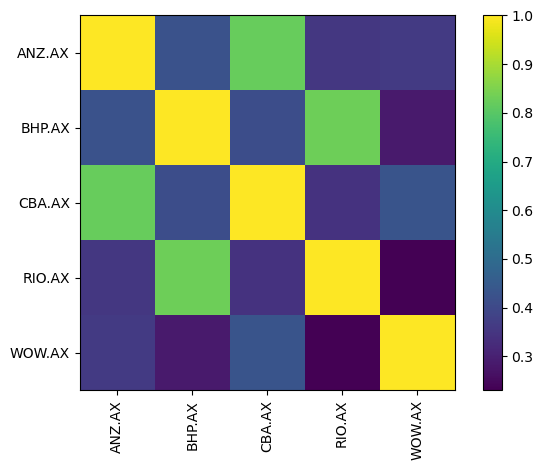

In [23]:
#Calculate Risk for efficient frontier model using annualised sample covariance. 
s = risk_matrix(stock_data_minus_index, method='sample_cov')

#Plot correlation
plotting.plot_covariance(s,show_tickers=True,plot_correlation=True)

#Plot covariance
# plotting.plot_covariance(s,show_tickers=True,plot_correlation=False)

In [24]:
#annualised Risk Free Rate
annual_risk_free_rate = pd.DataFrame(us10_data.mean())
annual_risk_free_rate = float(annual_risk_free_rate.iloc[0,0]) / 100
print(round(annual_risk_free_rate,2))

0.02


Expected annual return: 6.8%
Annual volatility: 16.6%
Sharpe Ratio: 0.27


<Axes: xlabel='Weight'>

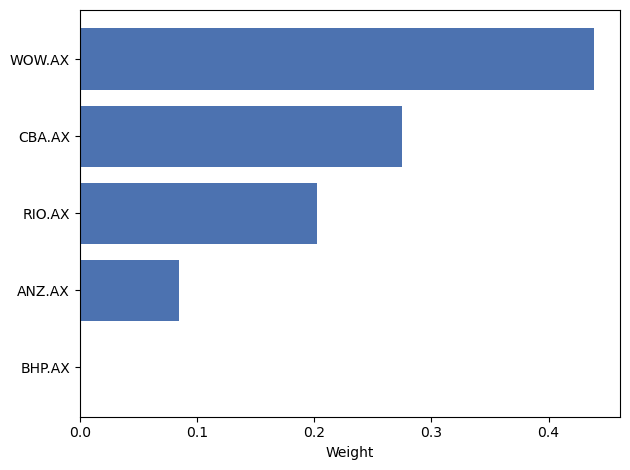

In [25]:
#Calculate Efficient Frontier with minimum volatility
ef = EfficientFrontier(mu, s)
weights = ef.min_volatility()
ef.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free_rate)
plotting.plot_weights(weights)


Expected annual return: 9.9%
Annual volatility: 19.8%
Sharpe Ratio: 0.39


<Axes: xlabel='Weight'>

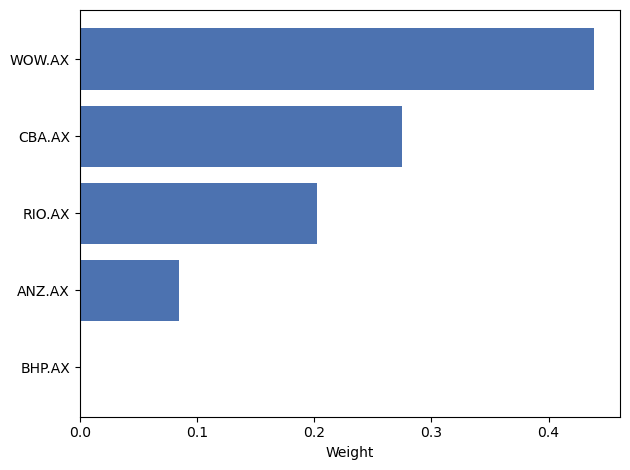

In [26]:
#Calculate efficient frontier with maximum Sharpe ratio
ef = EfficientFrontier(mu, s)
ef.max_sharpe(risk_free_rate=annual_risk_free_rate)
ef.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free_rate)
plotting.plot_weights(weights)

Expected annual return: 9.7%
Annual volatility: 20.7%
Sharpe Ratio: 0.36


c:\Users\siddh\anaconda3\envs\dev_fintech_course\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


<Axes: xlabel='Weight'>

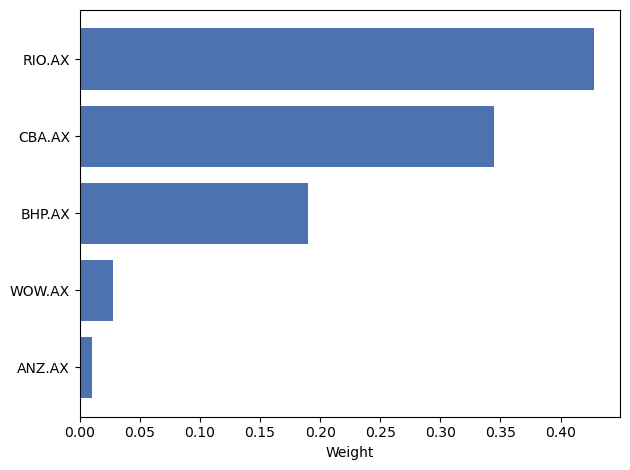

In [27]:
#Calcuate efficient frontier with constraints of minimum investment proportions of 1% for each stock
ef = EfficientFrontier(mu, s, weight_bounds=(0.01, 1))
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
weights = ef.max_sharpe(risk_free_rate=annual_risk_free_rate)
ef.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free_rate)
plotting.plot_weights(weights)

# Efficient Frontier Option 2 with Monte Carlo simulations

In [28]:
#Assigning number for number of stocks chosen
ticker_count_minus_1 = int(len(tickers)-1)
ticker_count_minus_1

# We'll need to change this because we are sending the index as a separate variable, not a part of the original tickers list 
ticker_count_minus_1 = len(tickers)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.12
Annualised Volatility: 0.19


            ANZ.AX  BHP.AX  CBA.AX  RIO.AX  WOW.AX
allocation    0.59    0.83   50.28   43.95    4.35
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.09
Annualised Volatility: 0.17


            ANZ.AX  BHP.AX  CBA.AX  RIO.AX  WOW.AX
allocation   10.08    1.94   26.82   19.31   41.85


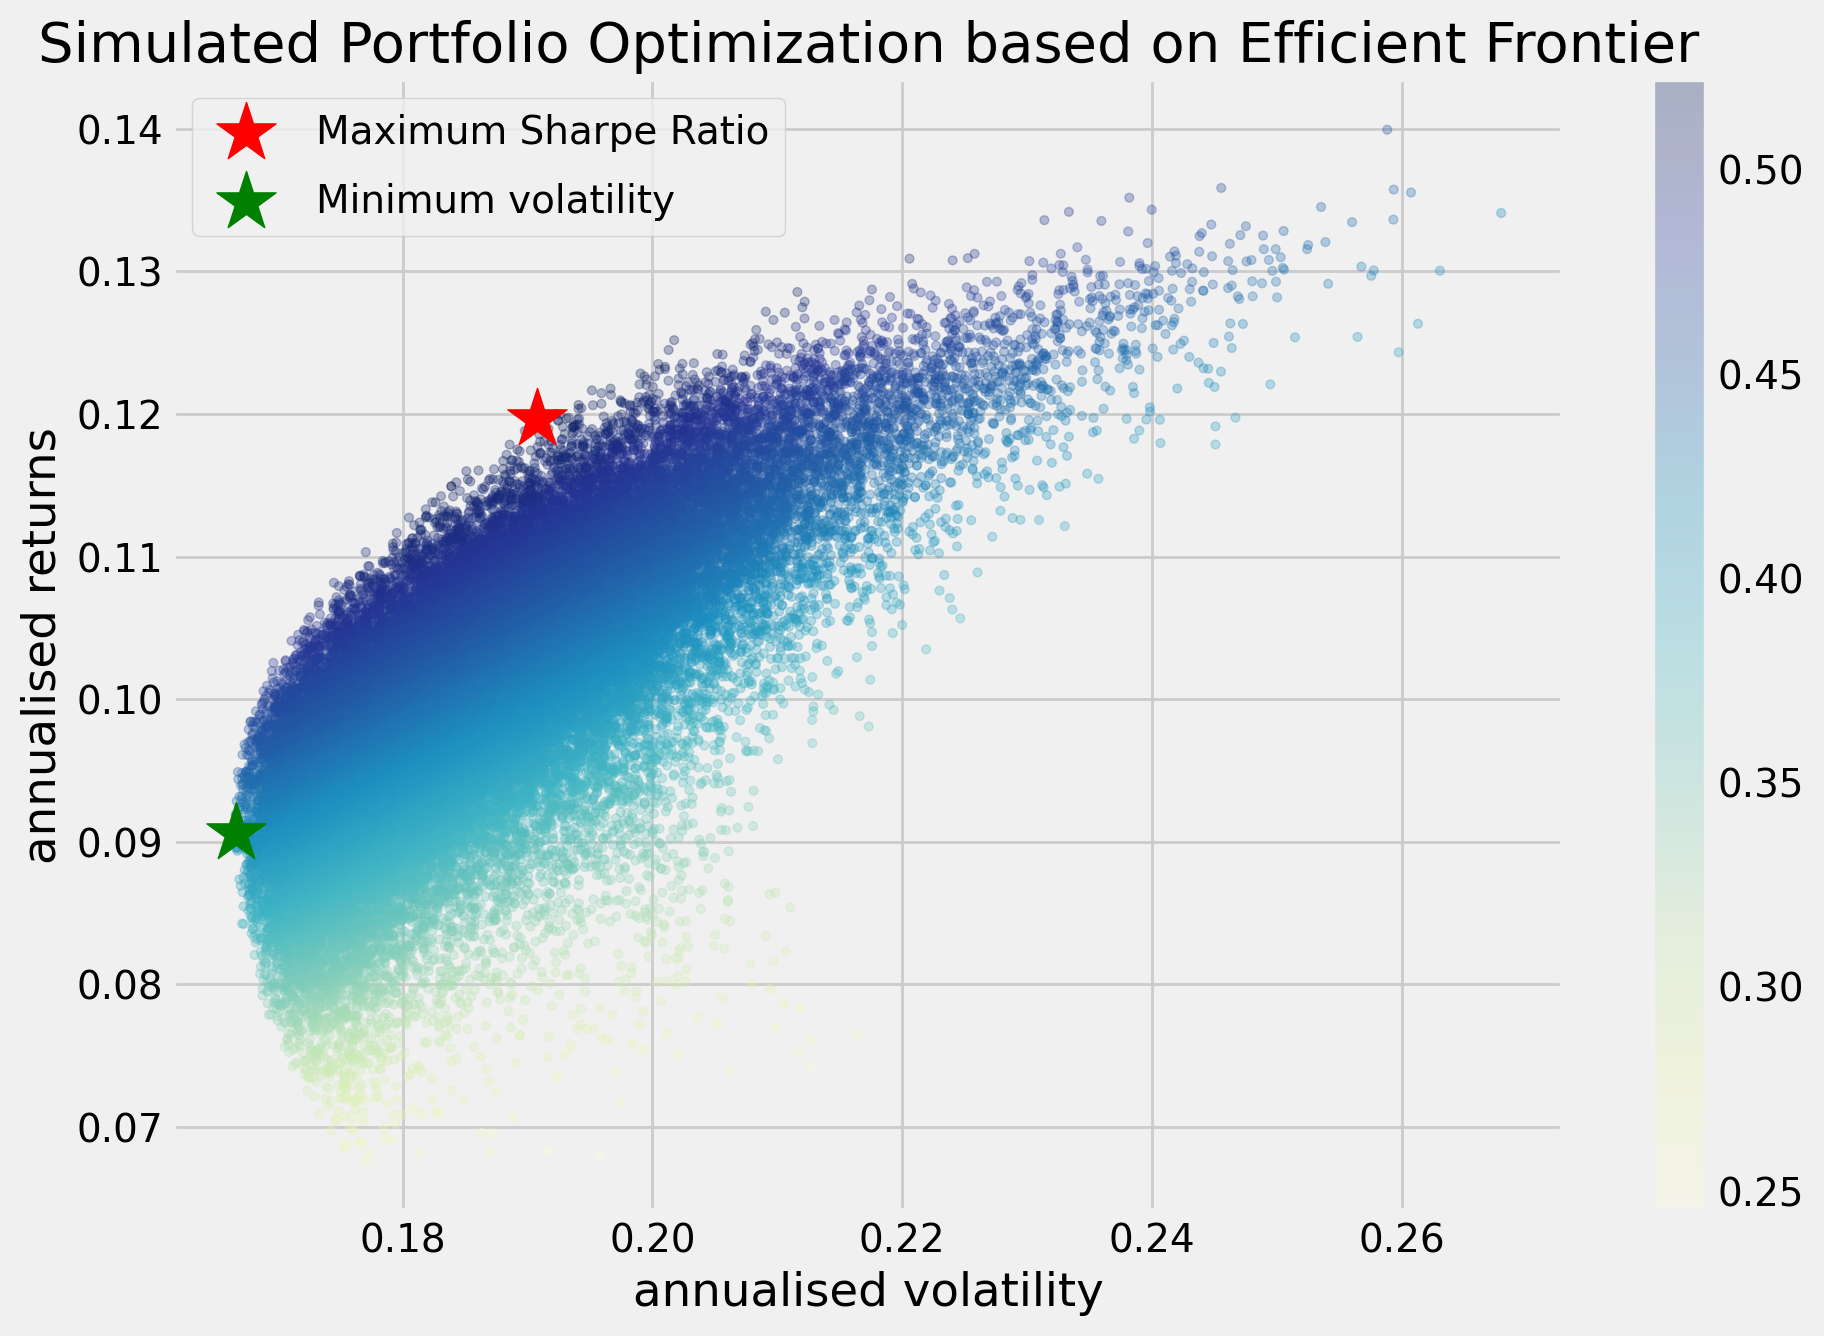

In [34]:
#New efficient frontier - Option 2 Using 25000 random portfolios and finding the max sharpe and min volatility allocations-----------------------------------------------------------------------------
# Reference https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f


# initialize random seed to generate pseudorandom numbers
plt.style.use('fivethirtyeight')
np.random.seed()

#configure jupyter notebook to display Matplotlib in high-resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((ticker_count_minus_1,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(ticker_count_minus_1)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

#inputs for the variables above
returns = stock_data_minus_index.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.02

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=stock_data_minus_index.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=stock_data_minus_index.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    # print("-"*80)
    # print("Maximum Sharpe Ratio Portfolio Allocation\n")
    # print("Annualised Return:", round(rp,2))
    # print("Annualised Volatility:", round(sdp,2))
    # print("\n")
    # print(max_sharpe_allocation)
    # print("-"*80)
    # print("Minimum Volatility Portfolio Allocation\n")
    # print("Annualised Return:", round(rp_min,2))
    # print("Annualised Volatility:", round(sdp_min,2))
    # print("\n")
    # print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r', s=500, label='Maximum Sharpe Ratio')
    plt.scatter(sdp_min,rp_min,marker='*', color='g', s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

       
#To display the frontier and data:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [30]:
results = np.zeros((ticker_count_minus_1,num_portfolios))
ticker_count_minus_1

5

In [57]:
#New efficient frontier - Option 2 Using 25000 random portfolios and finding the max sharpe and min volatility allocations-----------------------------------------------------------------------------
# Reference https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

import plotly.express  as px
import plotly.graph_objects as go

# initialize random seed to generate pseudorandom numbers
plt.style.use('fivethirtyeight')
np.random.seed()

#configure jupyter notebook to display Matplotlib in high-resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import plotly

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((ticker_count_minus_1,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(ticker_count_minus_1)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

#inputs for the variables above
returns = stock_data_minus_index.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.02

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=stock_data_minus_index.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=stock_data_minus_index.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    # print("-"*80)
    # print("Maximum Sharpe Ratio Portfolio Allocation\n")
    # print("Annualised Return:", round(rp,2))
    # print("Annualised Volatility:", round(sdp,2))
    # print("\n")
    # print(max_sharpe_allocation)
    # print("-"*80)
    # print("Minimum Volatility Portfolio Allocation\n")
    # print("Annualised Return:", round(rp_min,2))
    # print("Annualised Volatility:", round(sdp_min,2))
    # print("\n")
    # print(min_vol_allocation)
    
    # plt.figure(figsize=(10, 7))
    # plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    # plt.colorbar()
    # plt.scatter(sdp,rp,marker='*',color='r', s=500, label='Maximum Sharpe Ratio')
    # plt.scatter(sdp_min,rp_min,marker='*', color='g', s=500, label='Minimum volatility')
    # plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    # plt.xlabel('annualised volatility')
    # plt.ylabel('annualised returns')
    # plt.legend(labelspacing=0.8)

    fig = go.Figure()

    # Add scatter trace with medium sized markers
    fig.add_trace( go.Scatter(mode='markers', x=results[0,:], y=results[1,:], marker=dict( color='LightSkyBlue', size=4, opacity=0.5, 
                        line=dict( color='LightSkyBlue', width=2 ) ), showlegend=False ) )

    fig.add_trace( go.Scatter( mode='markers', x=[sdp], y=[rp], marker=dict( color='Green', size=20, opacity=0.8, 
                        line=dict( color='Green', width=8 ) ), showlegend=True, name="Maximum Sharpe Ratio" ) )

    fig.add_trace( go.Scatter( mode='markers', x=[sdp_min], y=[rp_min], marker=dict( color='Yellow', size=20, opacity=0.8, 
                        line=dict( color='Yellow', width=8 ) ), showlegend=True, name="Minimum Volatility" ) )


    fig.show()
       
#To display the frontier and data:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)